In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# import sys
# sys.path.append('../')
%cd ..

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from src.load_data import load_oil_price_data

import warnings
warnings.filterwarnings('ignore')

## Data loading

In [ ]:
start_date = "2022-09-26"
df = load_oil_price_data(start_date)

In [ ]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-10-16 00:00:00-04:00,78.629997,78.889999,77.870003,78.389999,5156200,0.0,0.0,0.0
2023-10-17 00:00:00-04:00,77.980003,78.879997,77.400002,78.800003,3914400,0.0,0.0,0.0
2023-10-18 00:00:00-04:00,79.720001,80.360001,79.320000,79.839996,4647300,0.0,0.0,0.0
2023-10-19 00:00:00-04:00,79.370003,81.750000,78.940002,81.680000,5924400,0.0,0.0,0.0
2023-10-20 00:00:00-04:00,81.589996,81.980003,80.169998,80.699997,4660500,0.0,0.0,0.0


<Axes: xlabel='Date'>

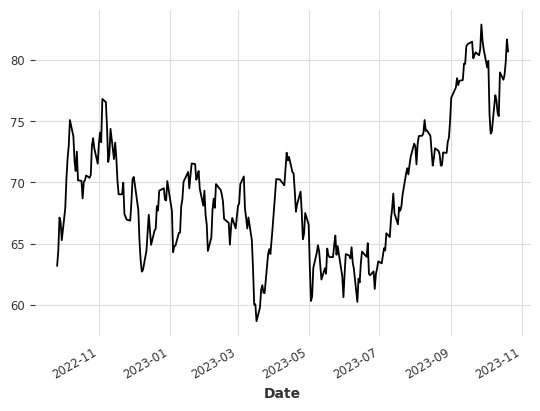

In [ ]:
df.Close.plot()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 270 entries, 2022-09-26 00:00:00-04:00 to 2023-10-20 00:00:00-04:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           270 non-null    float64
 1   High           270 non-null    float64
 2   Low            270 non-null    float64
 3   Close          270 non-null    float64
 4   Volume         270 non-null    int64  
 5   Dividends      270 non-null    float64
 6   Stock Splits   270 non-null    float64
 7   Capital Gains  270 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 19.0 KB


## Data Preprocessing

In [ ]:
resample_frequency = 'D'
df_resampled = df.resample(resample_frequency).asfreq()
for column in df.columns:
    df_resampled[f'{column}'].interpolate(method='linear', inplace=True)

df_resampled['MissingData'] = df_resampled['Open'].isnull().astype(int)

In [ ]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 390 entries, 2022-09-26 00:00:00-04:00 to 2023-10-20 00:00:00-04:00
Freq: D
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           390 non-null    float64
 1   High           390 non-null    float64
 2   Low            390 non-null    float64
 3   Close          390 non-null    float64
 4   Volume         390 non-null    float64
 5   Dividends      390 non-null    float64
 6   Stock Splits   390 non-null    float64
 7   Capital Gains  390 non-null    float64
 8   MissingData    390 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 30.5 KB


<Axes: xlabel='Date'>

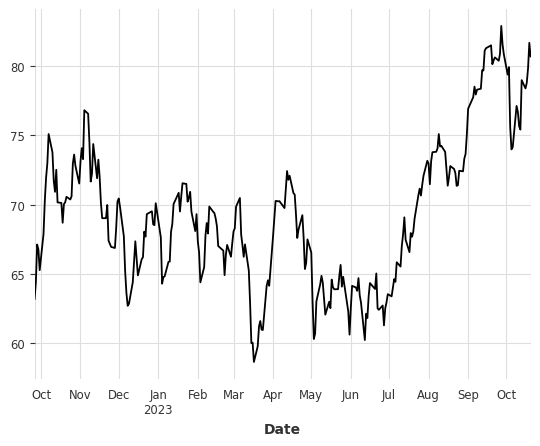

In [ ]:
df_resampled.Close.plot()

# darts lib

In [ ]:
!pip install darts

In [ ]:
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from darts.utils.statistics import check_seasonality
from darts.metrics import mape, r2_score
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.models import RNNModel
import pandas as pd

In [ ]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df_resampled, value_cols="Close")

In [ ]:
# Set aside the last 36 months as a validation series
train, val = series[:-36], series[-36:]

In [ ]:
# Как будто нет сезонности
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

In [ ]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))
    print("model {} obtains R2: {:.2f}%".format(model, r2_score(val, forecast)))

## GRU

In [ ]:
eval_model(ExponentialSmoothing())

model ExponentialSmoothing() obtains MAPE: 4.02%
model ExponentialSmoothing() obtains R2: -1.93%


In [ ]:
eval_model(TBATS())

model TBATS() obtains MAPE: 1.97%
model TBATS() obtains R2: 0.15%


In [ ]:
GRU_model = RNNModel(
    model="GRU",
    input_chunk_length=32,
    n_rnn_layers=10,
    training_length=30,
    n_epochs=20,
)
eval_model(GRU_model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 37.2 K
4 | V             | Linear           | 26    
---------------------------------------------------
37.2 K    Trainable params
0         Non-trainable params
37.2 K    Total params
0.149     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

model RNNModel(model=GRU, n_rnn_layers=10, training_length=30, input_chunk_length=32, n_epochs=20) obtains MAPE: 88.95%
model RNNModel(model=GRU, n_rnn_layers=10, training_length=30, input_chunk_length=32, n_epochs=20) obtains R2: -895.88%


In [ ]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()